In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import scipy.special as sp
import sklearn.datasets as datasets
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import econml
import importlib
import pyreadr

#### data generation packages
import strawman_edge
import strawman_center
import all_linear

#### main packages
import characterize
import estimate_atte as est
import learn_w as learn
import black

importlib.reload(est)
importlib.reload(learn)

import warnings

warnings.filterwarnings("ignore")

%load_ext jupyter_black
sns.set(font_scale=1.25, style="whitegrid")
np.random.seed(0)

In [2]:
outcome_cols = ["opioiduse12", "opioiduse24"]
treatment_col = "medicine_assigned"
discrete_cov = ["xrace", "mar", "sex"]

baseline_harmonized = pd.read_csv(
    "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/updated_data/ctn0094/drv/clean_patients_with_relapse_wide.csv",
    index_col=0,
)

# baseline_harmonized = baseline_harmonized.rename(
#     columns={col: col.split(".")[1] for col in baseline_harmonized.columns}
# ).set_index("who")

stacked_list = []
for i in range(1, 6):
    stacked_list.append(
        pd.read_csv(
            "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/stacked_list_%d.csv"
            % (i),
            index_col=0,
        )
    )
df = stacked_list[0]

df_tedsa = df.loc[df["trialdata"] == 0]

## TEDS-A vs CTN 27

In [3]:
ct94 = baseline_harmonized.loc[(baseline_harmonized["project"] == 27)]
outcome94 = ct94[outcome_cols]

common_cols = set.intersection(set(df_tedsa.columns), set(ct94.columns))

ct94_cc = ct94[common_cols].dropna()
ct94_cc["sex"] = (ct94["sex"] == "male").astype(int)  # male = 1 and female = 0
ct94_cc["mar"].loc[(1 - ct94_cc["mar"].isna()) == 1] = (ct94_cc["mar"] == 1.0).astype(
    int
)
ct94_cc["edu"].loc[(1 - ct94_cc["edu"].isna()) == 1] = (ct94_cc["edu"] >= 2.0).astype(
    int
)

imputer = KNNImputer(n_neighbors=4, weights="distance", add_indicator=False)
ct94_cc_imputed = imputer.fit_transform(ct94_cc)

ct94_cc = pd.DataFrame(ct94_cc_imputed, index=ct94_cc.index, columns=ct94_cc.columns)

ct94_cc["med_met"] = (ct94[treatment_col] == "met").astype(
    int
)  # methadone = 1 and bupenorphine = 0
ct94_cc = ct94_cc.dropna()

ct94_cc["S"] = 1
ct94_cc = ct94_cc.round(0).astype(int)

ct94_cc = ct94_cc.join(outcome94, how="inner")
print(ct94_cc.shape)
ct94_cc.groupby(by="med_met").mean()[outcome_cols]

(161, 13)


,opioiduse12,opioiduse24
med_met,,
0,0.594937,0.759494
1,0.500000,0.597561


In [4]:
df_tedsa_cc = df_tedsa[common_cols]
df_tedsa_cc["S"] = 0
# invert age categories
df_tedsa_cc["age"].replace(
    {
        1: 13,
        2: 16,
        3: 18,
        4: 22,
        5: 27,
        6: 32,
        7: 37,
        8: 42,
        9: 47,
        10: 52,
        11: 60,
        12: 68,
    },
    inplace=True,
)

df_tedsa_cc["mar"].loc[(1 - df_tedsa_cc["mar"].isna()) == 1] = (
    df_tedsa_cc["mar"] == 1.0
).astype(int)
df_tedsa_cc["edu"].loc[(1 - df_tedsa_cc["edu"].isna()) == 1] = (
    df_tedsa_cc["edu"] >= 2.0
).astype(int)

In [5]:
df_primary = pd.concat([df_tedsa_cc.sample(frac=1, replace=False), ct94_cc])

df_ = df_primary.drop(columns=[outcome_cols[0]]).fillna(0)

In [6]:
outcome = outcome_cols[1]
treatment = "med_met"
sample = "S"
data = df_
S = df_[sample]  # indicator for the sample
Y = df_[outcome]  # outcome variable
T = df_[treatment]  # indicator for the treatment

data_dummy = pd.get_dummies(data, columns=["xrace"])
data_dummy.rename(
    columns={
        "sex": "Sex",
        "age": "Age",
        "ivdrug": "IV Drug Use",
        "bamphetamine30_base": "Hx Amphetamine",
        "bbenzo30_base": "Hx Benzo",
        "bcannabis30_base": "Hx Cannabis",
        "xrace_1": "White",
        "xrace_2": "Black",
        "xrace_3": "Hispanic",
        "xrace_4": "Other Race",
        "mar": "Married",
        "edu": "Education(12y)",
    },
    inplace=True,
)

X = data_dummy.drop(columns=[outcome, treatment, sample])  # pre-treatment covariates

In [7]:
data_dummy.groupby(by="S").mean().T.round(2)

S,0,1
IV Drug Use,0.54,0.78
Hx Amphetamine,0.07,0.12
Sex,0.58,0.63
Married,0.14,0.16
Education(12y),0.72,0.73
Age,38.07,37.47
Hx Cannabis,0.11,0.22
Hx Benzo,0.06,0.20
med_met,0.00,0.51
opioiduse24,0.00,0.68


#### CTN Analysis

In [8]:
print(
    (
        100
        * (
            data_dummy.loc[
                (data_dummy[sample] == 1) * (data_dummy[treatment] == 1), outcome
            ].mean()
            - data_dummy.loc[
                (data_dummy[sample] == 1) * (data_dummy[treatment] == 0), outcome
            ].mean()
        ),
        1.96
        * 100
        * np.sqrt(
            data_dummy.loc[
                (data_dummy[sample] == 1) * (data_dummy[treatment] == 1), outcome
            ].var()
            / data_dummy.loc[
                (data_dummy[sample] == 1) * (data_dummy[treatment] == 1), outcome
            ].shape[0]
            + data_dummy.loc[
                (data_dummy[sample] == 1) * (data_dummy[treatment] == 0), outcome
            ].var()
            / data_dummy.loc[
                (data_dummy[sample] == 1) * (data_dummy[treatment] == 1), outcome
            ].shape[0]
        ),
    )
)

mu_ctn27_1 = lm.RidgeCV().fit(
    data_dummy.loc[(data_dummy[sample] == 1) * (data_dummy[treatment] == 1)].drop(
        columns=[sample, treatment, outcome]
    ),
    data_dummy.loc[(data_dummy[sample] == 1) * (data_dummy[treatment] == 1), outcome],
)

mu_ctn27_0 = lm.RidgeCV().fit(
    data_dummy.loc[(data_dummy[sample] == 1) * (data_dummy[treatment] == 0)].drop(
        columns=[sample, treatment, outcome]
    ),
    data_dummy.loc[(data_dummy[sample] == 1) * (data_dummy[treatment] == 0), outcome],
)

te_ctn27 = mu_ctn27_1.predict(
    data_dummy.loc[(data_dummy[sample] == 1)].drop(columns=[sample, treatment, outcome])
) - mu_ctn27_0.predict(
    data_dummy.loc[(data_dummy[sample] == 1)].drop(columns=[sample, treatment, outcome])
)

posterior_project_te = en.GradientBoostingRegressor().fit(
    data_dummy.loc[(data_dummy[sample] == 1)].drop(
        columns=[sample, treatment, outcome]
    ),
    te_ctn27,
)

pd.Series(
    posterior_project_te.feature_importances_,
    index=data_dummy.loc[(data_dummy[sample] == 1)]
    .drop(columns=[sample, treatment, outcome])
    .columns,
).sort_values()

(-16.193269527631994, 14.167788838773127)


Hx Amphetamine    0.000458
Education(12y)    0.001302
Hispanic          0.007296
Other Race        0.008821
Hx Benzo          0.048778
Black             0.057857
IV Drug Use       0.058412
Married           0.063380
Sex               0.073225
Age               0.196215
White             0.216355
Hx Cannabis       0.267902
dtype: float64

#### Transporting Effects

In [9]:
importlib.reload(learn)
# D, w_tree, testing_data = learn.tree_opt(data, outcome, treatment, sample, leaf_proba=1)
np.random.seed(42)
D_rash, D_forest, w_forest, rashomon_set, f, testing_data = learn.forest_opt(
    data=data_dummy,
    outcome=outcome,
    treatment=treatment,
    sample=sample,
    leaf_proba=0.5,
    num_trees=4000,
    vote_threshold=3 / 4,
    # top_k_trees=True,
    # k=50,
)

baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((D_forest.shape[0] ** 2)))
print("Baseline Objective:%.4f" % (baseline_loss))

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
ATE Est: 0.0541
leaf              0.333333
IV Drug Use       0.063029
Hx Amphetamine    0.003030
Sex               0.022136
Married           0.011007
Education(12y)    0.060416
Age               0.003274
Hx Cannabis       0.110303
Hx Benzo          0.045238
White             0.102216
Black             0.086880
Hispanic          0.087237
Other Race        0.071901
dtype: float64
Baseline Objective:0.0798


Number of Selected Trees: 1389


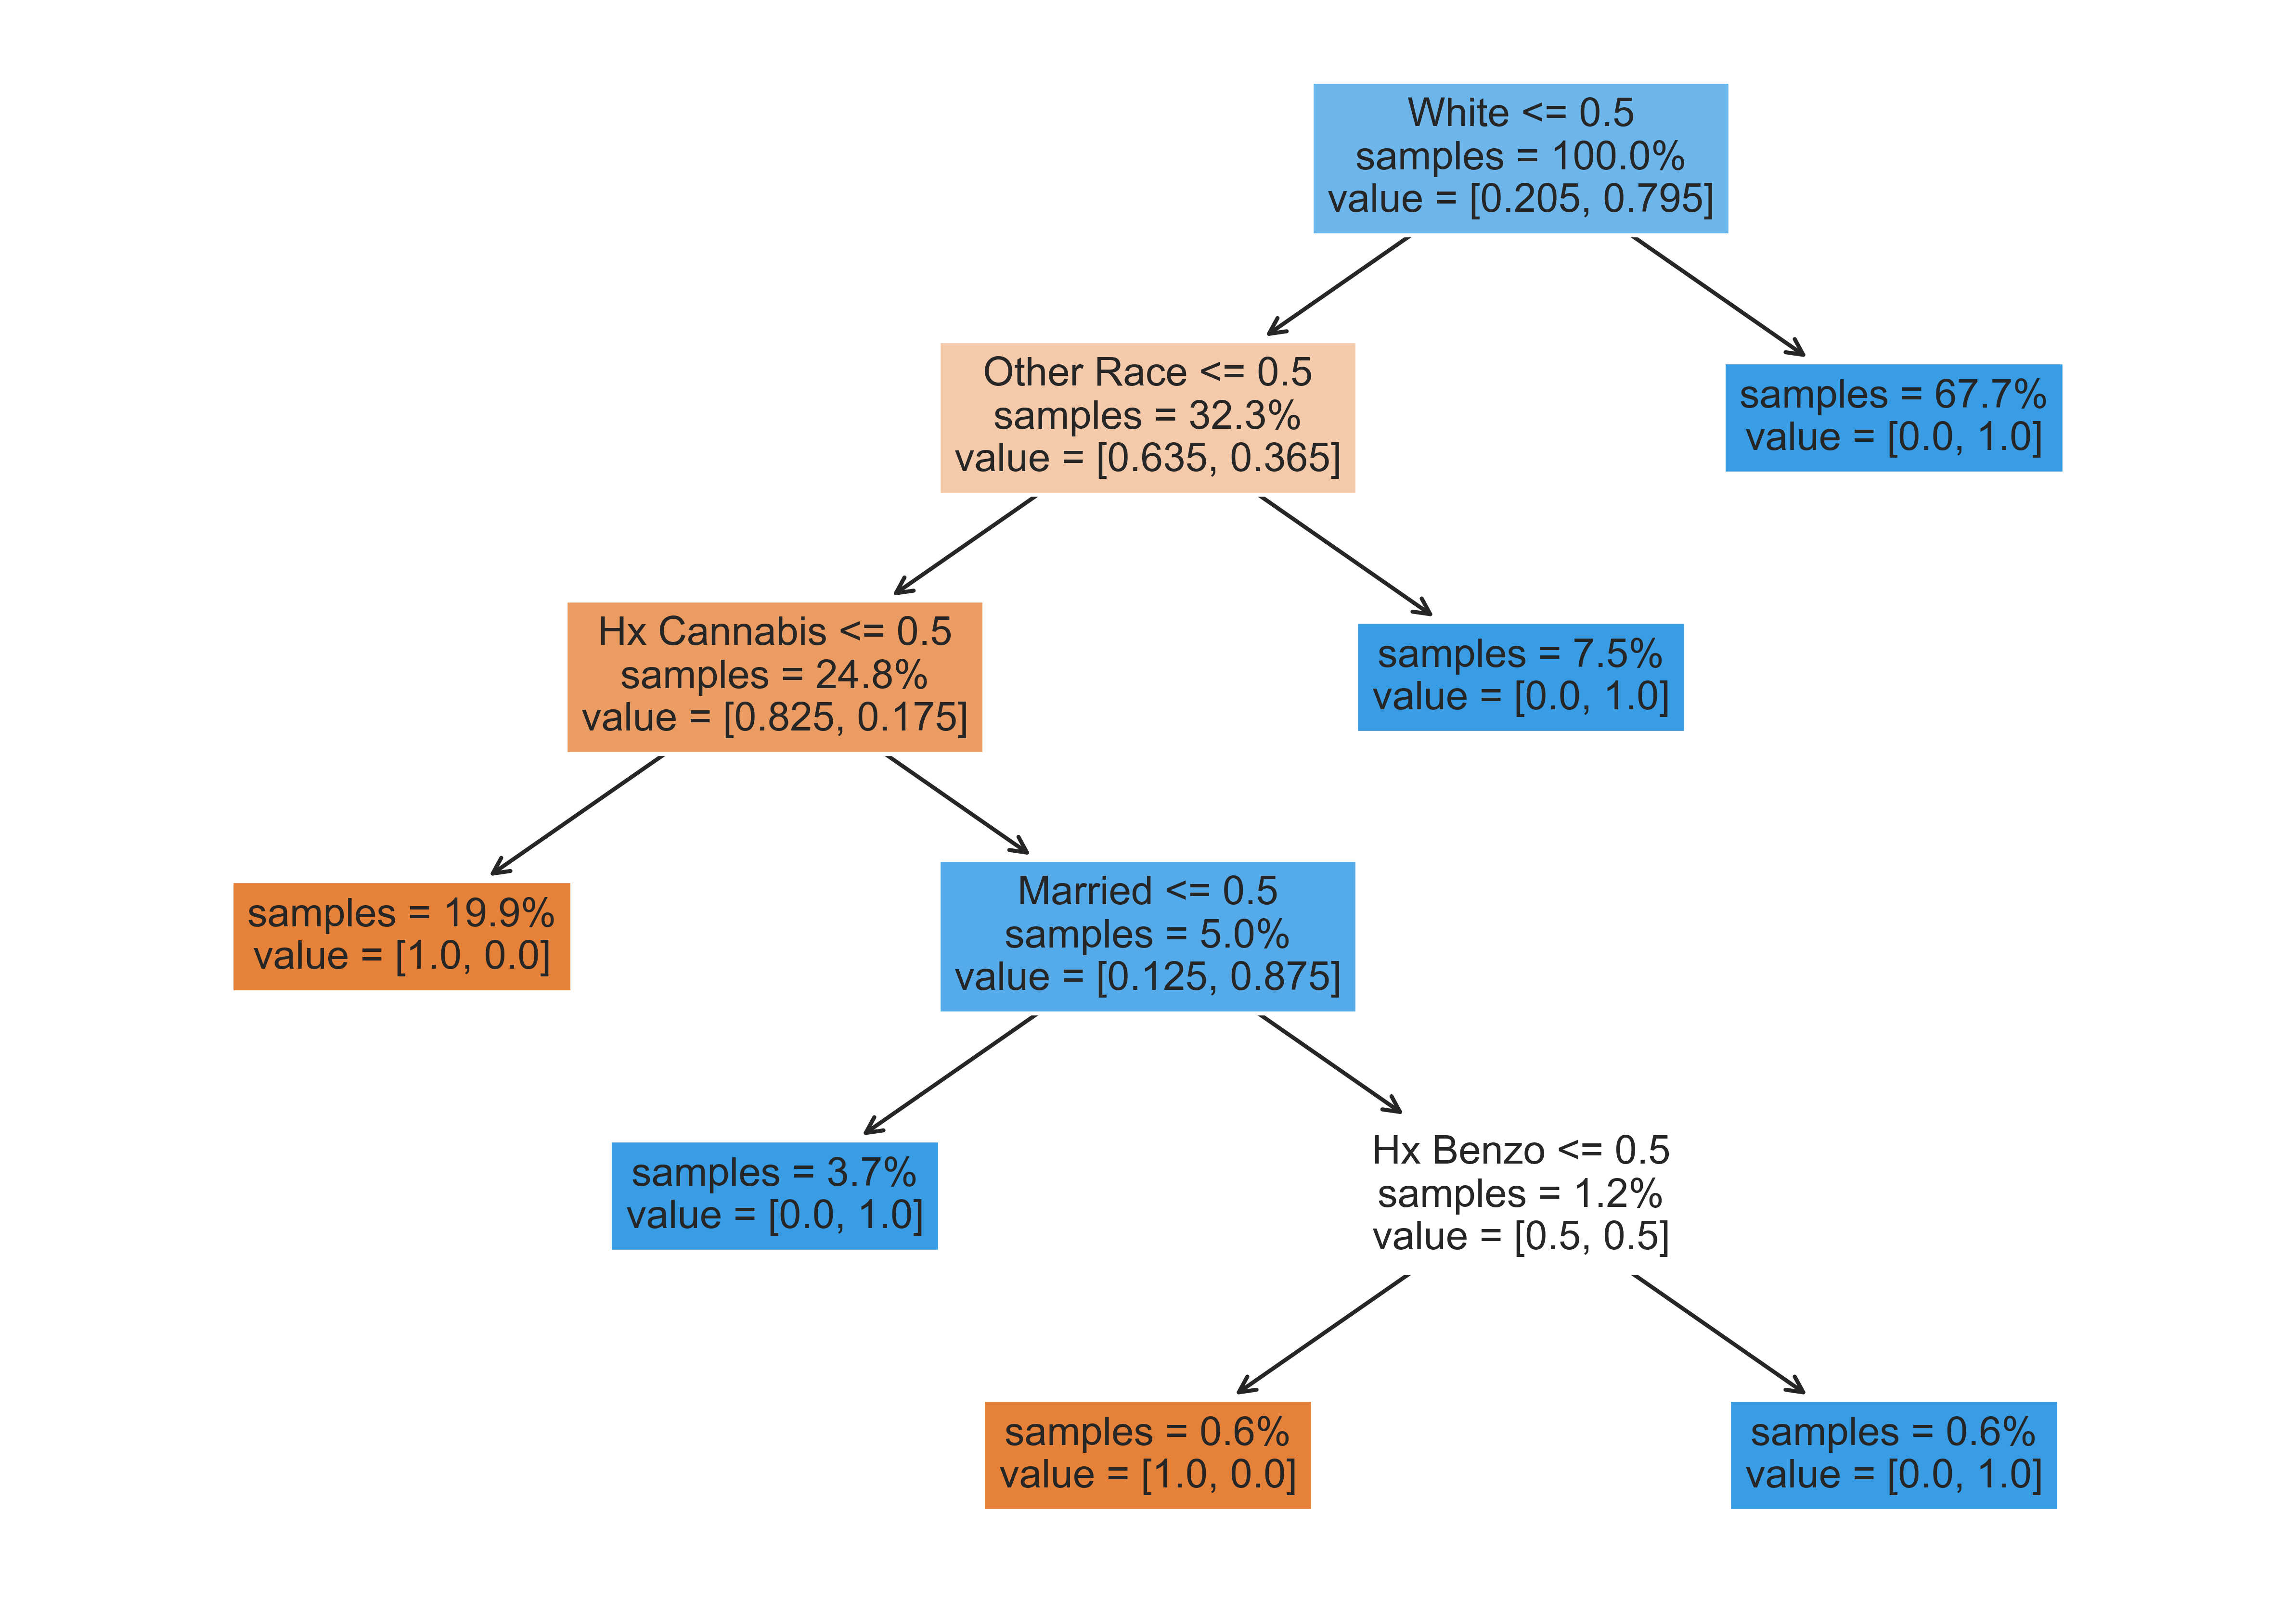

In [10]:
local_obj = np.array(
    [
        w_forest[i]["local objective"]
        for i in range(len(w_forest))
        if w_forest[i]["local objective"] < baseline_loss
    ]
)

w_rash = [
    "w_tree_%d" % (i)
    for i in range(len(w_forest))
    if w_forest[i]["local objective"] < baseline_loss
]
print("Number of Selected Trees: %d" % (len(w_rash)))
avg_votes = (D_forest[w_rash].mean(axis=1) >= 0.8).astype(int)

np.random.seed(42)
num_trees = 1
explainer = tree.DecisionTreeClassifier(max_leaf_nodes=6).fit(
    X.loc[avg_votes.index], avg_votes
)

# explainer = en.GradientBoostingClassifier(
#     # base_estimator=tree.DecisionTreeClassifier(max_depth=3)
# ).fit(X.loc[avg_votes.index], avg_votes)

# print(len(explainer.estimators_))

# num_trees = min(2, len(explainer.estimators_))
fig, ax = plt.subplots(nrows=num_trees, figsize=(10, 7 * num_trees), dpi=600)
for i in range(num_trees):
    if num_trees == 1:
        tree.plot_tree(
            explainer,  # .estimators_[i, 0],
            feature_names=X.columns,
            ax=ax,
            filled=True,
            fontsize=10,
            proportion=True,
            impurity=False,
        )
    else:
        tree.plot_tree(
            explainer.estimators_[i, 0],
            feature_names=X.columns,
            ax=ax[i],
            filled=True,
            fontsize=10,
            proportion=True,
        )
plt.savefig("tedsa_ctn27.pdf", dpi=600)

In [11]:
# D_rash = pd.read_csv("tedsa_analysis_forest_rashomon_opt.csv", index_col=0)

# np.random.seed(42)
# explainer = en.GradientBoostingClassifier(
#     # base_estimator=tree.DecisionTreeClassifier(max_depth=3)
# ).fit(D_rash[X1.columns], D_rash["w_opt"])

w = explainer.predict(data_dummy[X.columns])
data_dummy["w"] = w

pd.concat(
    [
        data_dummy.groupby(by="S").mean().T.round(2),
        data_dummy.loc[data_dummy["w"] == 1].groupby(by="S").mean().T.round(2),
    ],
    axis=1,
)

S,0,1,0,1
IV Drug Use,0.54,0.78,0.58,0.77
Hx Amphetamine,0.07,0.12,0.07,0.11
Sex,0.58,0.63,0.56,0.61
Married,0.14,0.16,0.14,0.14
Education(12y),0.72,0.73,0.76,0.79
Age,38.07,37.47,35.53,35.61
Hx Cannabis,0.11,0.22,0.15,0.27
Hx Benzo,0.06,0.20,0.07,0.23
med_met,0.00,0.51,0.00,0.51
opioiduse24,0.00,0.68,0.00,0.68


In [12]:
print(
    r"Pre Pruning, SATE: %.2f ± %.2f"
    % (
        100
        * (
            df_.loc[(df_[sample] == 1) * (df_[treatment] == 1), outcome].mean()
            - df_.loc[(df_[sample] == 1) * (df_[treatment] == 0), outcome].mean()
        ),
        100
        * 1.96
        * (
            df_.loc[(df_[sample] == 1) * (df_[treatment] == 1), outcome].sem()
            + df_.loc[(df_[sample] == 1) * (df_[treatment] == 0), outcome].sem()
        ),
    )
)

print(
    r"Pre Pruning, ATTE: %.2f ± %.2f"
    % (
        100 * D_rash["v"].mean(),
        100 * 1.96 * np.sqrt(D_rash["vsq"].mean() / D_rash["w_opt"].count()),
    )
)

print(
    r"Post Pruning, ATTE: %.2f ± %.2f"
    % (
        100 * D_rash["v"].loc[D_rash["w_opt"] == 1].mean(),
        100
        * 1.96
        * np.sqrt(
            D_rash["vsq"].loc[D_rash["w_opt"] == 1].mean() / D_rash["w_opt"].sum()
        ),
    )
)

Pre Pruning, SATE: -16.19 ± 20.16
Pre Pruning, ATTE: 5.41 ± 15.64
Post Pruning, ATTE: -6.66 ± 14.96


(0.07687519794065487, 0.07977070728814546)


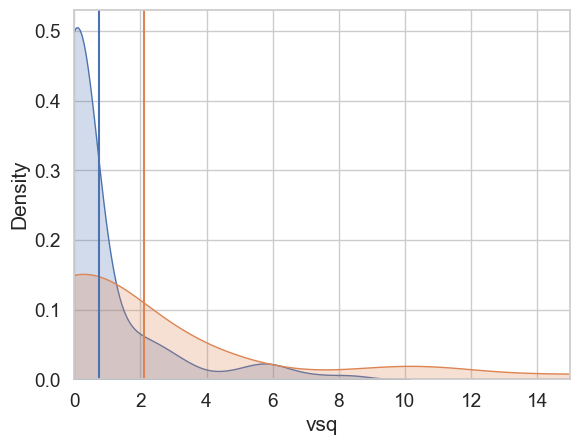

In [13]:
sns.kdeplot(D_rash.loc[D_rash["w_opt"] == 1]["vsq"], fill=True)
sns.kdeplot(D_rash.loc[D_rash["w_opt"] == 0]["vsq"], fill=True)
plt.axvline(D_rash.loc[D_rash["w_opt"] == 1]["vsq"].mean(), c="C0")
plt.axvline(D_rash.loc[D_rash["w_opt"] == 0]["vsq"].mean(), c="C1")
plt.xlim(0, 15)
print(
    (
        np.sqrt(
            D_rash.loc[data_dummy["w"] == 1]["vsq"].mean()
            / D_rash.loc[data_dummy["w"] == 1]["vsq"].count()
        ),
        np.sqrt(D_rash["vsq"].mean() / D_rash["vsq"].count()),
    )
)

(-0.06658255326590878, 0.5404989965660109)


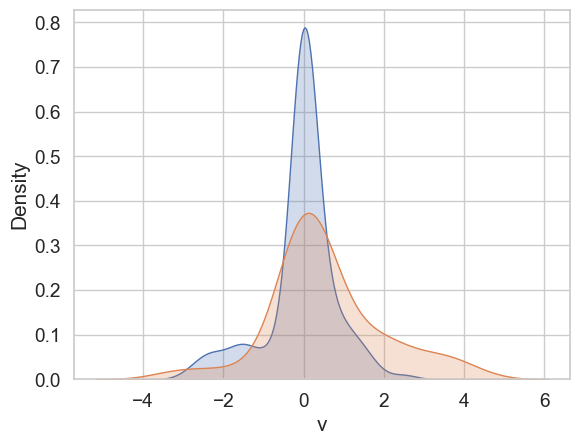

In [18]:
sns.kdeplot(D_rash.loc[D_rash["w_opt"] == 1]["v"], fill=True)
sns.kdeplot(D_rash.loc[D_rash["w_opt"] == 0]["v"], fill=True)
print(
    (
        D_rash.loc[D_rash["w_opt"] == 1]["v"].mean(),
        D_rash.loc[D_rash["w_opt"] == 0]["v"].mean(),
    )
)

In [15]:
D_forest.to_csv("tedsa_analysis_forest_opt.csv")
D_rash.to_csv("tedsa_analysis_forest_rashomon_opt.csv")

In [16]:
data_dummy["w"].loc[data_dummy["S"] == 1].sum() / data_dummy["w"].loc[
    data_dummy["S"] == 1
].count()

0.7950310559006211